# WATERHYPERNET In-situ and Satellite matchup data

### **BRIEF INTRODUCTION**

WATERHYPERNET is a prototype network of automated in situ measurements of
hyperspectral water reﬂectance suitable for satellite validation and water quality
monitoring.
Radiometric validation of satellite-derived water reﬂectance is
essential to ensure that only reliable data, e.g., for estimating water quality
parameters such as chlorophyll a concentration, reach end-users.
Analysis of the differences between satellite and in situ water reﬂectance measurements,
particularly unmasked outliers, can provide recommendations on where satellite
data processing algorithms need to be improved.


**GOAL**: To demonstrate the use of WATERHYPERNET insitu measurement data to validate S2/MSI data


This activity focusses on Demonstration cases comparing PANTHYR (PAN and Tilt HYperspectral Radiometer) data from WATERHYPERNET site Oostende (O1BE) and Acqua Alta (VEIT) with Sentinel-2 data. This jupyter notebook provides codes for matchup analysis and visualization of data.


**DATA SOURCE:**
Dataset to be used in this jupyter notebook can be downloaded in Ruddick et. al., 2024 WATERHYPERNET paper (https://www.frontiersin.org/journals/remote-sensing/articles/10.3389/frsen.2024.1347520/full#supplementary-material).
Please download **Data Sheet 1.CSV**.

**CREDITS:** site PIs (V. Brando, D. Vansteenwegen), ACOLITE and matchup processing (Q. Vanhellemont), ipynb preparation (A. Gammaru and K. Ruddick) AND the whole HYPERNETS team.




---

## Start of the Exercise

### **Q1**. Reproduce the scatterplots of S2-Insitu matchup
Here, the first task (**Q1**) is to reproduce the scatterplot shown in Figure 5 right column, p.12 of [Ruddick et al, https://doi.org/10.3389/frsen.2024.1347520 ].
The supplementary data, **Data Sheet 1.CSV** contains only satellite matchups processed with "ACOLITE/DSF+GC". The file contains matchups from 2 validation sites of WATERHYPERNET Networks (Ostend, Belgium **O1BE**, Aqua Alta, Venice, Italy, **VEIT**) with Sentinel-2/MSI.

Reflectance parameters are given by column names, for example:

**‘rhos_’** satellite reflectance at wavelength (e.g., **‘rhos_443’**) at wavelength available [443, 492, 560, 665, 704, 740, 783, 883, 865 ]

**‘rhos_insitu_**’ in-situ reflectance (e.g., **‘rhos_insitu_443’**) available wavelength [443, 492, 560, 665, 704, 740, 783, 883, 865 ]

**‘rhot_’** top of atmosphere reflectance (e.g., **‘rhot_443’**) available wavelength [443, 492, 560, 665, 704, 740, 783, 883, 865, 945, 1373, 1614, 2202 ]

In [ ]:
# Importing necessary packages
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

# Import data file downloaded from Ruddick et al 2024 WATERHYPERNETS Data_sheet_1

# Update the filepath to your file location
filename = '/content/Data Sheet 1.CSV'

# Check if the file exists
if os.path.isfile(filename):
    df = pd.read_csv(filename)
    print(df.head())  # print dataframe
    # print(df.columns.tolist())

else:
    print(f"File {filename} does not exist")

   site   sensor              isodate  \
0  VEIT  S2A_MSI  2022-02-17T10:11:01   
1  VEIT  S2A_MSI  2022-11-21T10:03:44   
2  VEIT  S2B_MSI  2021-02-17T10:10:23   
3  VEIT  S2A_MSI  2021-02-09T10:04:05   
4  VEIT  S2B_MSI  2020-11-26T10:03:41   

                                             product         saa        sza  \
0  S2A_MSIL1C_20220217T101101_N0400_R022_T33TUL_2...  161.922503  59.206746   
1  S2A_MSIL1C_20221121T100321_N0400_R122_T33TUL_2...  168.430426  66.292115   
2  S2B_MSIL1C_20210217T101029_N0209_R022_T33TUL_2...  161.881841  59.124977   
3  S2A_MSIL1C_20210209T100141_N0209_R122_T33TUL_2...  159.858523  62.336652   
4  S2B_MSIL1C_20201126T100339_N0209_R122_T33TUL_2...  168.210288  67.446193   

        vza         vaa  ac_aot_550                 ac_model  ...  rhos_865  \
0  7.937409  286.137117    0.677270  ACOLITE-LUT-202110-MOD1  ...  0.013079   
1  6.980039  105.774068    0.274954  ACOLITE-LUT-202110-MOD1  ...  0.005523   
2  7.989949  285.224534    0.450922  ACOL

In [ ]:
# Install libraries not in Colab
!pip install pylr2
import pylr2

In [ ]:
# Calculate yearly records

def calculate_yearly_records(df, site):
    # Filter df to keep records where 'site' is matching input site
    df_site = df[df['site'].str.lower() == site.lower()]

    # Extract the timestamp for these records
    timestamp_site = df_site['isodate']

    # Convert the timestamp to a datetime object
    datetime_obj_site = pd.to_datetime(timestamp_site, format='%Y-%m-%dT%H:%M:%S')

    # Extract the year
    year_site = datetime_obj_site.dt.year

    # Calculate the number of data entries for each year in the pandas Series
    data_counts_per_year = year_site.value_counts()

    # Sort the resulting Series by the index (i.e., year) for readability
    data_counts_per_year = data_counts_per_year.sort_index()

    # Return the result
    return data_counts_per_year

In [ ]:
# Compute matchups statistics
from pylr2 import regress2

def compute_stats(df, wave, Band):

    # Initialize an empty list to hold statistics
    stats_MU = []

    # Function to compute root mean square error
    def rmse(predictions, targets):
        return np.sqrt(((np.asarray(predictions) - np.asarray(targets)) ** 2).mean())

    # Compute statistics for each band
    for index, wl in enumerate(wave):
        stats_data = {
            'bands':0.0,
            'rs_wv': 0.0,
            'N': 0,
            'slope': 0.0,
            'intercept': 0.0,
            'RMSD': 0.0,
            'MD': 0.0,
            'DETER(r2)': 0.0,
            'MAPD':0.0
        }

        # Get observed values
        ref_obs = df[f'rhos_insitu_{wl}'].values
        sat_obs = df[f'rhos_{wl}'].values

        # Perform regression
        results = regress2(ref_obs, sat_obs, _method_type_2="reduced major axis")

        # Update statistics data
        stats_data.update({
            'slope': results['slope'],
            'intercept': results['intercept'],
            'RMSD': rmse(sat_obs, ref_obs),
            'N': len(ref_obs),
            'MD': np.mean(sat_obs - ref_obs),
            'DETER(r2)': results['r']**2,
            'MAPD': np.mean(np.abs(sat_obs - ref_obs) / (0.5 * (sat_obs + ref_obs))) * 100,
            'rs_wv': wl,
            'bands': Band[index]
        })

        # Append the statistics data to the list
        stats_MU.append(stats_data)

    # Create DataFrame from the list
    return pd.DataFrame(stats_MU)

# bands and wavelengths
Band = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A']
wave = [443,492,560,665,704,740,783,833,865] # wavelength

stats_MU = compute_stats(df, wave, Band)

# Print match-up results
#stats_MU


In [ ]:
# function for plotting Exercise Question 3,4,5 for selected wavelength

def plot_question(Q,wavelength):

    wave=np.array(stats_MU['rs_wv'])
    i=np.argmin(np.abs(wavelength - stats_MU['rs_wv']))

    fig, ax = plt.subplots(figsize=(5.5,4.5))
    if Q==3:
        colors = {'sza_0_40': 'skyblue',
                  'sza_40_50': 'orange',
                  'sza_50_60':'darkgreen',
                  'sza_60_70':'fuchsia'}
        color_list = [colors[group] for group in df['cat_sza']]

        plt.scatter(df['rhos_insitu_'+ str(wave[i])],df['rhos_'+ str(wave[i])],s=6,c=color_list,marker='o')
        handles = [ Line2D([0], [0], color=colors['sza_0_40'],marker='o',linestyle=''),
                   Line2D([0], [0], color=colors['sza_40_50'],marker='o',linestyle=''),
                   Line2D([0], [0], color=colors['sza_50_60'],marker='o',linestyle=''),
                   Line2D([0], [0], color=colors['sza_60_70'],marker='o',linestyle='')]
        labels = [ 'sza=0-40°', 'sza=40-50°','sza=50-60°','sza=60-70°']
        ax.legend(handles,labels, bbox_to_anchor=(1.01, 1),loc="upper left", borderaxespad=0)

    elif Q==4:
        color_list=df['rhot_1373']
        x= color_list
       # norm = mpl.colors.Normalize(vmin=np.min(x), vmax=np.max(x))
        norm = mpl.colors.Normalize(vmin=0, vmax=0.0045)
        plt.scatter(df['rhos_insitu_'+ str(wave[i])],df['rhos_'+ str(wave[i])],s=6,c=color_list,cmap='jet',norm=norm,marker='o')
        cb=plt.colorbar()
        cb.set_label(r"$\rho_{t}$ 1373 nm ")

    elif Q==5:
        color_list=df['rhot_1614']
        x= color_list
        #norm = mpl.colors.Normalize(vmin=np.min(x), vmax=np.max(x))
        norm = mpl.colors.Normalize(vmin=0, vmax=0.045)
        plt.scatter(df['rhos_insitu_'+ str(wave[i])],df['rhos_'+ str(wave[i])],s=6,c=color_list,cmap='jet',norm=norm,marker='o')
        cb=plt.colorbar()
        cb.set_label(r"$\rho_{t}$ 1614 nm ")

    plt.plot(df['rhos_insitu_'+ str(wave[i])], stats_MU['intercept'][i] + stats_MU['slope'][i]*df['rhos_insitu_'+ str(wave[i])], 'r', label='fitted line')
    ax.plot([-0.01, .14], [0, 0],color='grey',linestyle = 'dotted')
    ax.plot([0, 0], [-0.01, .14],color='grey',linestyle = 'dotted')
    ax.plot([0, 1], [0, 1],color='grey',linestyle = '--', transform=ax.transAxes)
    ax.set_xlim(-0.01, 0.14)
    ax.set_ylim(-0.01, 0.14)

    fs=7
    t_x=0.07
    equation = 'y  = ' + str("{:.2f}".format(stats_MU['slope'][i])) + 'x' ' + ' + str("{:.2e}".format(stats_MU['intercept'][i]))
    plt.text(t_x,0.03,equation,fontsize=fs)
    plt.text(t_x,0.026,"n= {:.0f}".format(len(ref_obs)),fontsize=fs)
    plt.text(t_x,0.021,"R$^2$={:.3f}".format(stats_MU['DETER(r2)'][i]),fontsize=fs)
    plt.text(t_x,0.017,"RMSD={:.2e}".format(stats_MU['RMSD'][i]),fontsize=fs)
    plt.text(t_x,0.0125,"MD={:.2e}".format(stats_MU['MD'][i]),fontsize=fs)
    plt.text(t_x,0.008,"MAPD={:.1f}".format(stats_MU['MAPD'][i])+'%',fontsize=fs)
    plt.title('ACOLITE/DSF+GC' + ' ' + str(stats_MU['bands'][i]) + ' ' + str(stats_MU['rs_wv'][i]) +'nm')
    plt.xlabel(r"$\rho_{w}$ NoSC PANTHYR (1) ")
    plt.ylabel(r"$\rho_{w}$ MSI (1) ")

In [ ]:
# function for plotting Question 3,4,5 for all wave bands

wave =[443,492,560,665,704,740,783,833,865]

def plot_questions(Q):
        for i in range(len(wave)):
            fig, ax = plt.subplots(figsize=(5.5,4.5))
            if Q==3:
                colors = {'sza_0_40': 'skyblue',
                          'sza_40_50': 'orange',
                          'sza_50_60':'darkgreen',
                          'sza_60_70':'fuchsia'}
                color_list = [colors[group] for group in df['cat_sza']]
                plt.scatter(df['rhos_insitu_'+ str(wave[i])],df['rhos_'+ str(wave[i])],s=6,
                            c=color_list,marker='o')
                handles = [ Line2D([0], [0], color=colors['sza_0_40'],marker='o',linestyle=''),
                           Line2D([0], [0], color=colors['sza_40_50'],marker='o',linestyle=''),
                           Line2D([0], [0], color=colors['sza_50_60'],marker='o',linestyle=''),
                           Line2D([0], [0], color=colors['sza_60_70'],marker='o',linestyle='')]

                labels = [ 'sza=0-40°', 'sza=40-50°','sza=50-60°','sza=60-70°']
                ax.legend(handles,labels, bbox_to_anchor=(1.01, 1),loc="upper left", borderaxespad=0)

            elif Q==4:
                color_list=df['rhot_1373']
                x= color_list
                #norm = mpl.colors.Normalize(vmin=np.min(x), vmax=np.max(x))
                norm = mpl.colors.Normalize(vmin=0, vmax=0.0045)
                plt.scatter(df['rhos_insitu_'+ str(wave[i])],df['rhos_'+ str(wave[i])],s=6,c=color_list,cmap='jet',norm=norm,marker='o')
                cb=plt.colorbar()
                cb.set_label(r"$\rho_{t}$ 1373 nm ")

            elif Q==5:
                color_list=df['rhot_1614']
                x= color_list
                #norm = mpl.colors.Normalize(vmin=np.min(x), vmax=np.max(x))
                norm = mpl.colors.Normalize(vmin=0, vmax=0.045)
                plt.scatter(df['rhos_insitu_'+ str(wave[i])],df['rhos_'+ str(wave[i])],s=6,c=color_list,cmap='jet',norm=norm,marker='o')
                cb=plt.colorbar()
                cb.set_label(r"$\rho_{t}$ 1614 nm ")

            plt.plot(df['rhos_insitu_'+ str(wave[i])], stats_MU['intercept'][i] + stats_MU['slope'][i]*df['rhos_insitu_'+ str(wave[i])], 'r', label='fitted line')
            ax.plot([-0.01, .14], [0, 0],color='grey',linestyle = 'dotted')
            ax.plot([0, 0], [-0.01, .14],color='grey',linestyle = 'dotted')
            ax.plot([0, 1], [0, 1],color='grey',linestyle = '--', transform=ax.transAxes)
            ax.set_xlim(-0.01, 0.14)
            ax.set_ylim(-0.01, 0.14)

            fs=7
            t_x=0.07
            equation = 'y= ' + str("{:.2f}".format(stats_MU['slope'][i])) + 'x' ' + ' + str("{:.2e}".format(stats_MU['intercept'][i]))
            plt.text(t_x,0.03,equation,fontsize=fs)
            plt.text(t_x,0.026,"n= {:.0f}".format(len(ref_obs)),fontsize=fs)
            plt.text(t_x,0.021,"R$^2$={:.3f}".format(stats_MU['DETER(r2)'][i]),fontsize=fs)
            plt.text(t_x,0.017,"RMSD={:.2e}".format(stats_MU['RMSD'][i]),fontsize=fs)
            plt.text(t_x,0.0125,"MD={:.2e}".format(stats_MU['MD'][i]),fontsize=fs)
            plt.text(t_x,0.008,"MAPD={:.1f}".format(stats_MU['MAPD'][i])+'%',fontsize=fs)
            plt.title('ACOLITE/DSF+GC' + ' ' + str(stats_MU['bands'][i]) + ' ' + str(stats_MU['rs_wv'][i]) +'nm')
            plt.xlabel(r"$\rho_{w}$ NoSC PANTHYR (1) ")
            plt.ylabel(r"$\rho_{w}$ MSI (1) ")

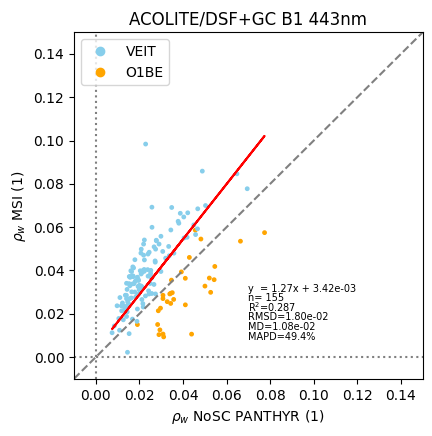

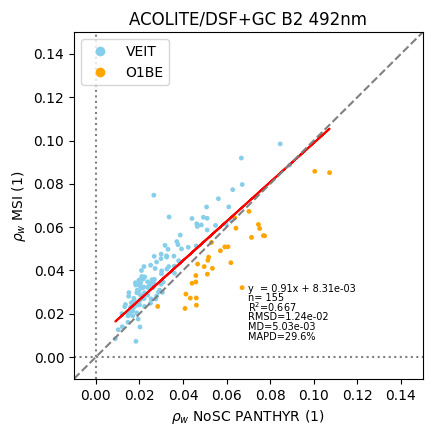

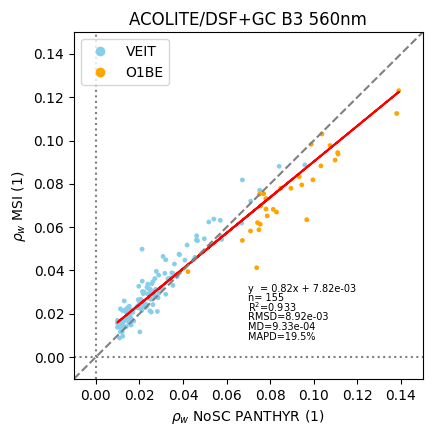

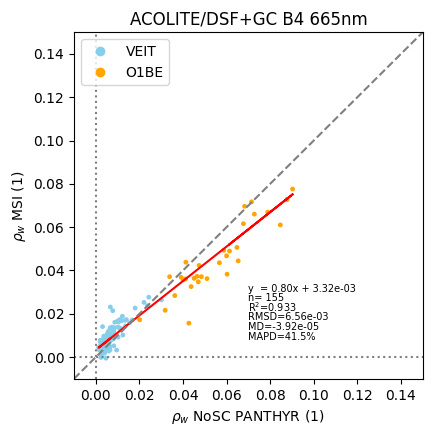

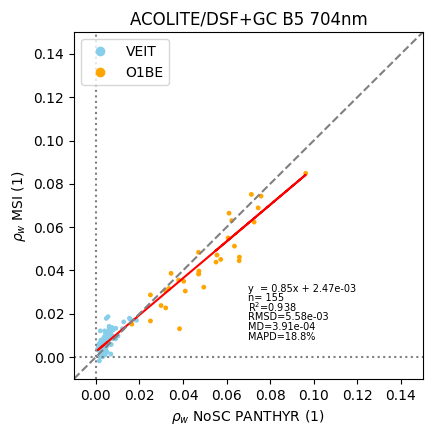

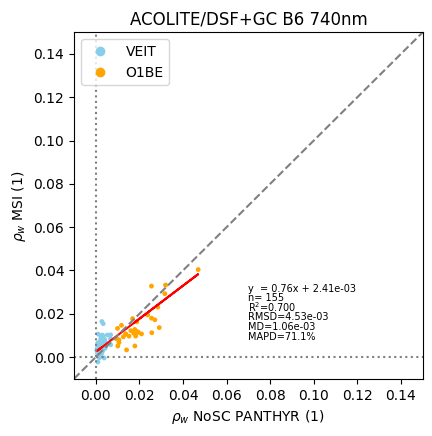

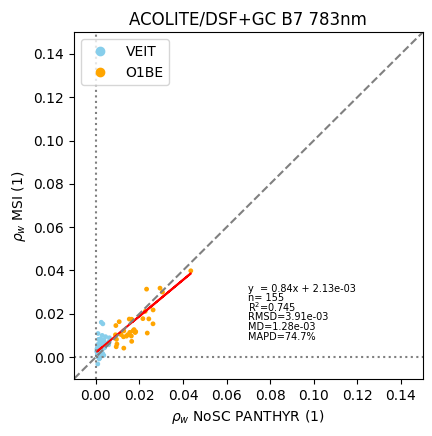

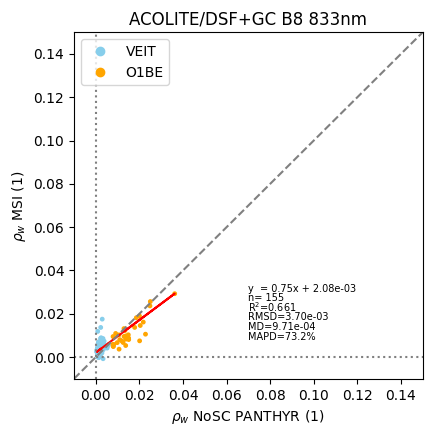

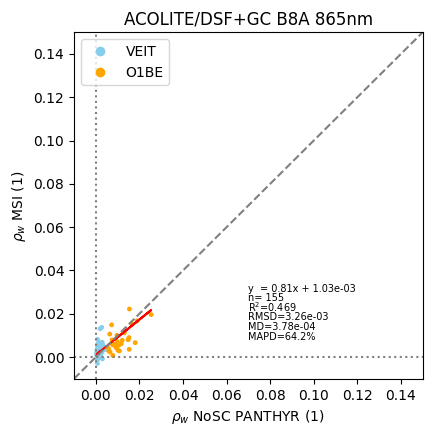

In [ ]:
# Plotting Q1: Reproduce the scatterplots of S2-Insitu matchup

stats_MU = compute_stats(df, wave, Band)

from matplotlib.lines import Line2D

# Get color for each data point
colors = dict(VEIT='skyblue', O1BE='orange')
color_list = [colors[group] for group in df['site']]

for i in range(len(wave)):
    fig, ax = plt.subplots(figsize=(4.5,4.5))

    # Create a scatter plot with color-coding based on 'categorical_variable'
    plt.scatter(df['rhos_insitu_'+ str(wave[i])],df['rhos_'+ str(wave[i])],s=6,c=color_list,marker='o')
    plt.plot(df['rhos_insitu_'+ str(wave[i])], stats_MU['intercept'][i] + stats_MU['slope'][i]*df['rhos_insitu_'+ str(wave[i])], 'r', label='fitted line')
    handles = [ Line2D([0], [0], color=colors['VEIT'], label='VEIT',marker='o', linestyle=''), Line2D([0], [0], color=colors['O1BE'], label='O1BE', marker='o', linestyle='')]

    labels = [ 'VEIT', 'O1BE']
    ax.legend(handles,labels,loc='upper left')

    ax.plot([-0.01, .15], [0, 0],color='grey',linestyle = 'dotted')
    ax.plot([0, 0], [-0.01, .15],color='grey',linestyle = 'dotted')
    ax.plot([0, 1], [0, 1],color='grey',linestyle = '--', transform=ax.transAxes)
    ax.set_xlim(-0.01, 0.15)
    ax.set_ylim(-0.01, 0.15)

    fs=7
    t_x=0.07

    equation = 'y  = ' + str("{:.2f}".format(stats_MU['slope'][i])) + 'x' ' + ' + str("{:.2e}".format(stats_MU['intercept'][i]))
    plt.text(t_x,0.03,equation,fontsize=fs)
    plt.text(t_x,0.026,"n= {:.0f}".format(stats_MU['N'][i]),fontsize=fs)
    plt.text(t_x,0.021,"R$^2$={:.3f}".format(stats_MU['DETER(r2)'][i]),fontsize=fs)
    plt.text(t_x,0.017,"RMSD={:.2e}".format(stats_MU['RMSD'][i]),fontsize=fs)
    plt.text(t_x,0.0125,"MD={:.2e}".format(stats_MU['MD'][i]),fontsize=fs)
    plt.text(t_x,0.008,"MAPD={:.1f}".format(stats_MU['MAPD'][i])+'%',fontsize=fs)
    plt.title('ACOLITE/DSF+GC' + ' ' + str(stats_MU['bands'][i]) + ' ' + str(stats_MU['rs_wv'][i]) +'nm')
    plt.xlabel(r"$\rho_{w}$ NoSC PANTHYR (1) ")
    plt.ylabel(r"$\rho_{w}$ MSI (1) ")
    plt.show()

### **Q1**. How much matchup data do O1BE and VEIT sites have per year?

In [ ]:
# Print the number of matchups and site of interest
site='veit'
#site='o1be'
data_counts = calculate_yearly_records(df, site)
print(f"The number of data entries for each year in '{site}' is:\n{data_counts}")


The number of data entries for each year in 'veit' is:
isodate
2019     9
2020    35
2021    30
2022    32
2023    18
Name: count, dtype: int64


**[Q1 answer box]** Type your answer here. At the end of this exercise, you will upload your answer in wooclap quiz!

### **Q2**. Identify the worst “outlier” matchup for the VEIT (Acqua Alta, Adriatic) site by comparing satellite (“rhos_443” column) and in situ (“rhos_insut_443) surface reflectance at 443nm and taking the matchup with largest absolute difference. Plot the satellite (“rhos”) and in situ (“rhos_insitu”) surface reflectance spectra (y) as function of wavelength (x) for this matchup. What do you see? What could cause that difference? [with more time you can make this comparison for the worst 3 matchups, the worst 10 matchups, it is very revealing …]

In [ ]:
# Select site to process
# df = pd.read_csv('Data_Sheet_1.CSV',delimiter=',')

df_veit=df[df["site"]=='VEIT']
df_veit.reset_index(drop=True, inplace=True)
df=df_veit

# compute matchups statistics
stats_MU = compute_stats(df, wave, Band)
# print(stats_MU)

# print matchup results
stats_MU

,bands,rs_wv,N,slope,intercept,RMSD,MD,DETER(r2),MAPD
0,B1,443,124,1.535370,0.003399,0.018938,0.015931,0.636734,52.420177
1,B2,492,124,1.187390,0.003987,0.011825,0.009378,0.836270,30.633093
2,B3,560,124,1.021894,0.003711,0.006630,0.004297,0.905002,20.518576
3,B4,665,124,1.192833,0.001111,0.004021,0.002419,0.671749,46.333193
4,B5,704,124,1.363232,0.000572,0.003608,0.002227,0.505193,18.619195
5,B6,740,124,2.364190,-0.000472,0.003619,0.002568,0.185940,78.880339
6,B7,783,124,2.469161,-0.000627,0.003381,0.002352,0.171387,85.098443
7,B8,833,124,2.567086,-0.000644,0.003217,0.002184,0.105386,82.380416
8,B8A,865,124,2.558232,-0.001154,0.002461,0.001314,0.083475,66.353867


Dates of the 1 highest abs_diff values @ 443nm are: 0    2022-02-17T10:11:01
Name: isodate, dtype: object


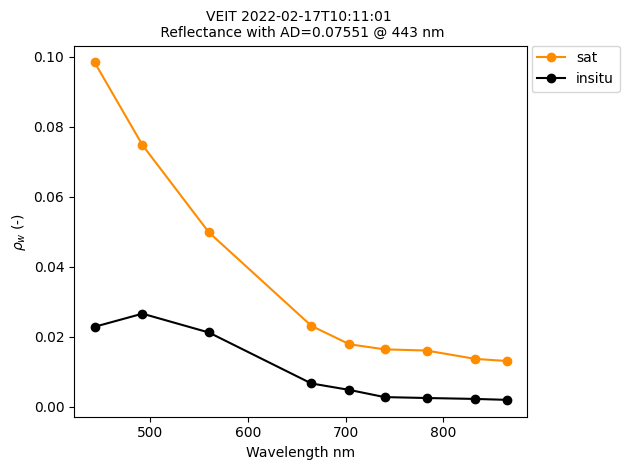

In [ ]:
# Compute for Absolute difference and plotting

wavelength = 443
i = np.argmin(np.abs(wavelength - stats_MU['rs_wv']))

wave = [443,492,560,665,704,740,783,833,865] # wavelength

ref_obs = np.asarray(df['rhos_insitu_'+ str(wave[i])], dtype=np.float64)
sat_obs = np.asarray(df['rhos_'+ str(wave[i])], dtype=np.float64)

# Absolute difference
abs_diff = np.abs(sat_obs - ref_obs)
max_ad=np.max(abs_diff)

# Get the index of the maximum absolute difference
# res = np.where(abs_diff == max_ad)[0]

# Get the indices of the highest absolute differences ()

res = np.argsort(abs_diff)[::-1][:1]  # set how many matchup

# Get the indices of the lowest absolute differences ()
# res = np.argsort(abs_diff)[:5]  # set how many matchup e.g 5

# Print the results

print('Dates of the ' + str(len(res)) + ' highest abs_diff values @ ' + str(wavelength) + 'nm are:', str(df['isodate'].iloc[res]))


def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, query_cols, sorter=sidx)]

indx = column_index(df, ['rhos_443', 'rhos_865', 'rhos_insitu_443', 'rhos_insitu_865'])


# Define plot dimensions
#plot_width = 6
#plot_height = 5

#plot_cols = 2  # Number of columns in subplot grid
#plot_rows = int(np.ceil(len(res) / plot_cols))  # Number of rows in subplot grid

#fig, axs = plt.subplots(plot_rows, plot_cols, figsize=(plot_width * plot_cols, plot_height * plot_rows))
fig, ax = plt.subplots()

# Flatten the array for easy iteration
# axs = axs.flatten()


# plotting Q2
for k in range(len(res)):
    # Pick an axis object from the flattened list
#    ax = axs[k]
    ax.plot(wave, df.iloc[res[k],indx[0]:indx[1]+1], color='darkorange', marker='o', label='sat')
    ax.plot(wave, df.iloc[res[k],indx[2]:indx[3]+1], color='k', marker='o', label='insitu')
    ax.set_ylabel('rhow')
    ax.set_xlabel('Wavelength nm')
    ax.legend(bbox_to_anchor=(1.01, 1),loc="upper left", borderaxespad=0)
    ax.set_title('VEIT ' + str(df['isodate'].iloc[res].iloc[k]) + f' \n Reflectance with AD={np.round(abs_diff[res[k]],5)} @ {wavelength} nm', fontsize=10)
    ax.set_ylabel(r"$\rho_{w}$ (-) ")

# Adjust space between subplots
plt.tight_layout()


plt.show()

#plt.savefig("Q2_VHRODA.png", dpi=150)

**[Q2 answer box]** Type your answer here. At the end of this exercise, you will upload your answer in wooclap quiz!

### **Q3.** Take the matchups only for the VEIT site (filter on 1st column). Redo the scatterplots of Q1, i.e. insitu surface reflectance (x) vs satellite surface reflectance (y), but now colouring points as function of sun zenith angle (sza, column 6), e.g. different colours for sza=0-40°, 40-50°, 50-60°, 60-70°, 70-80°, 80-90°. Does performance depend on sun zenith angle? Why?


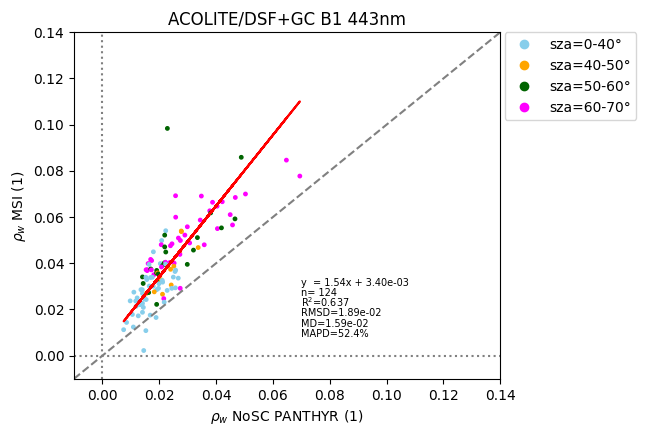

In [ ]:
# Define the category boundaries for SZA
bins = [0, 40, 50, 60, 71]

# Define the category names
categories = ['sza_0_40', 'sza_40_50', 'sza_50_60', 'sza_60_70']

# Create a new column in df, 'cat_sza'
# Use pd.cut to categorize 'sza' and store the result in 'cat_sza'
df['cat_sza'] = pd.cut(df['sza'], bins=bins, labels=categories, include_lowest=True)

# plotting
wavelength=443
Q=3
plot_question(Q,wavelength)

**[Q3 answer box]** Type your answer here. At the end of this exercise, you will upload your answer in wooclap quiz!

### **Q4.** Redo Q3 but colour points according to satellite Top Of Atmosphere reflectance at 1373nm (rhot_1373), the “cirrus band”. Does performance depend on TOA reflectance at 1373nm? Why?



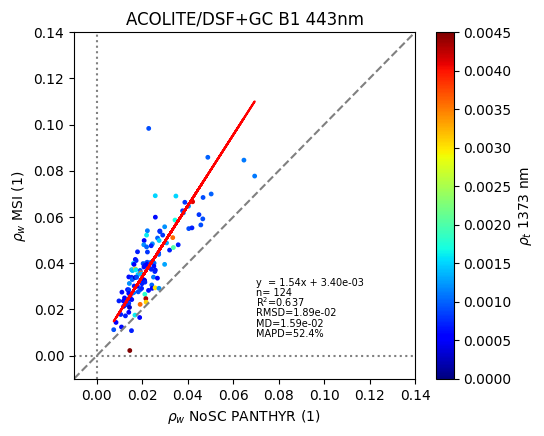

In [ ]:
wavelength=443
Q=4
plot_question(Q,wavelength)

**[Q4 answer box]** Type your answer here. At the end of this exercise, you will upload your answer in wooclap quiz!

  ### **Q5.** Redo Q3 but colour points according to satellite Top Of Atmosphere reflectance at 1614nm (rhot_1614), a SWIR band where water reflectance will be negligeable. Does performance depend on TOA refletance at 1614nm? Why?

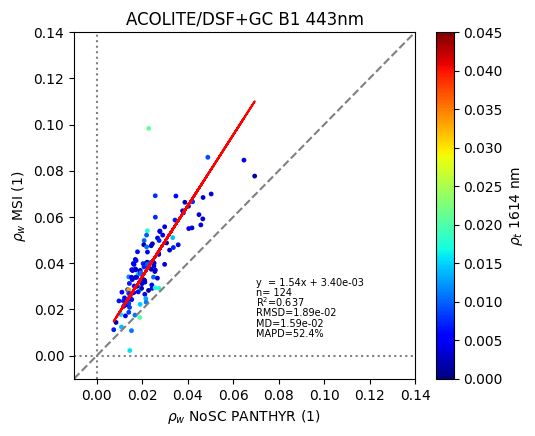

In [ ]:
wavelength=443
Q=5
plot_question(Q,wavelength)

**[Q5 answer box]** Type your answer here. At the end of this exercise, you will upload your answer in wooclap quiz!

In [ ]:
# Plotting all wavelengths for Q3
# Q=3
# plot_questions(Q)